<a href="https://colab.research.google.com/github/gaixen/Codes-from-scratch/blob/main/Neural_ODE/impl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing Dependencies

In [41]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [42]:
from IPython.display import clear_output
import math
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm
import matplotlib as mpl

import matplotlib.pyplot as plt
import seaborn as sns
sns.color_palette("bright")
import matplotlib as mpl
import matplotlib.cm as cm
import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F
from torch.autograd import Variable

In [43]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [44]:
pip install keras --quiet

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from matplotlib.animation import FuncAnimation
plt.style.use('ggplot')

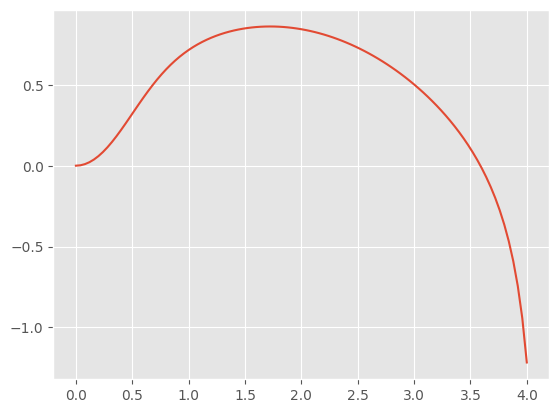

In [46]:
function = lambda y,x : (-4)*y**2 + 3*np.sin(x)
y0 = 0
T = 100
x = np.linspace(0, 4 , 101)
y = odeint(function , y0 , x)
plt.plot(x,y[:,0])
plt.xlabel = 'x'
plt.ylabel = 'y'
plt.show()

In [47]:
def ODE_solver_Euler(z0 , t0 , t1 , f):
    h_max = 0.01
    n_steps = math.ceil(((t1 - t0)/h_max).max().item())

    h = (t1 - t0)/n_steps
    t = t0
    z = z0

    for i in range(n_steps):
        z = z + h*f(t,z)
        t += h

    return z

In [48]:
class ODEF(nn.Module):
    def forward_with_grad(self , z, t , grad_output):
        batch_size = z.shape[0]
        out = self.forward(z , t)
        a = grad_output
        adfdz , adfdt , *adfdp = torch.autograd.grad(
            (out,),(z,t)+tuple(self.parameters()),grad_output = a,
            allow_unused = True , retain_graph = True) # a is adjoint

        if adfdp is not None:
            adfdp = torch.cat([p_grad.flatten() for p_grad in adfdp]).unsqueeze(0)
            adfdp = adfdp.expand(batch_size , -1)/batch_size
        if adfdt is not None:
            adfdt = adfdt.expand(batch_size , 1)/batch_size

        return out , adfdz , adfdt , adfdp

    def flatten_parameters(self):
        p_shapes = []
        flat_parameters = []

        for p in self.parameters():
            p_shapes.append(p.size())
            flat_parameters.append(p.flatten())

        return torch.cat(flat_parameters)


In [49]:
class ODEAdjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx , z0 ,t , flat_parameters , func):
        assert isinstance(func,ODEF)
        bs , *z_shape = z0.size()
        time_len = t.size(0)

        with torch.no_grad():
            z = torch.zeros(time_len , bs , *z_shape).to(z0)
            z[0] = z0
            for i_t in range(time_len -1):
                z0 = ODE_solver_Euler(z0 , t[i_t] , t[i_t +1],func)
                z[i_t+1] = z0

        ctx.func = func
        ctx.save_for_backward(t , z.clone() , flat_parameters)
        return z

    @staticmethod
    def backward(ctx , dldz):
        func = ctx.func
        t ,z, flat_parameters = ctx.saved_tensors
        time_len ,bs ,*z_shape = z.size()
        n_dim = np.prod(z_shape)
        n_params = flat_parameters.size(0)

        def augemented_dynamics(aug_z_i , t_i):
            z_i ,a = aug_z_i[:,:n_dim] , aug_z_i[: ,n_dim:2*n_dim]

            z_i = z_i.view(bs ,*z_shape)
            a = a.view(bs, *z_shape)

            with torch.set_grad_enabled(True):
                t_i = t_i.detach().requires_grad_(True)
                z_i = z_i.detach().requires_grad_(True)
                func_eval , adfdz , adfdt , adfdp = func.forward_with_grad(z_i , t_i , grad_output = a)
                adfdz = adfdz.to(z_i) if adfdz is not None else torch.zeros(bs,*z_shape).to(z_i)
                adfdp = adfdp.to(z_i) if adfdp is not None else torch.zeros(bs , n_params).to(z_i)
                adfdt = adfdt.to(z_i) if adfdt is not None else torch.zeros(bs,1).to(z_i)

            func_eval = func_eval.view(bs,n_dim)
            adfdz = adfdz.view(bs,n_dim)
            return torch.cat((func_eval , -adfdz , -adfdp , -adfdt),dim =1)

        dldz = dldz.view(time_len,bs,n_dim)
        with torch.no_grad():
            adj_z = torch.zeros(bs,n_dim).to(dldz)
            adj_p = torch.zeros(bs , n_params).to(dldz)
            adj_t = torch.zeros(bs,1).to(dldz)

            for i_t in range(time_len-1 ,0 ,-1):
                z_i = z[i_t]
                t_i = t[i_t]
                f_i = func(z_i , t_i).view(bs , n_dim)

                dldz_i = dldz[i_t]
                dldz_i = torch.bmm(torch.transpose(dldz_i.unsqueeze(-1),1,2),f_i.unsqueeze(-1))[:,0]

                adj_z += dldz_i
                adj_t[i_t]= adj_t[i_t] - dldz_i

                aug_z = torch.cat((z_i.view(bs , n_dim),adj_z , torch.zeros(bs,n_params).to(z),adj_t[i_t]),dim = -1)
                aug_ans = ODE_solver_Euler(aug_z , t_i , t[i_t-1] , augemented_dynamics)
                adj_z[:] = aug_ans[:,n_dim:2*n_dim]
                adj_p[:] += aug_ans[: , 2*n_dim:2*n_dim + n_params]
                adj_t[i_t-1] = aug_ans[: , 2*n_dim+n_params : ]

                del aug_z , aug_ans

            dldz_0 = dldz[0]
            dldt_0 = torch.bmm(torch.transpose(dldz_0.unsqueeze(-1),1,2),f_i.unsqueeze(-1))[:,0]

            adj_z += dldz_0
            adj_t[0] -= dldt_0

        return adj_z.view(bs , *z_shape),adj_t , adj_p , None



In [50]:
class NeuralODE(nn.Module):
    def __init__(self,func):
        super(NeuralODE,self).__init__()
        assert isinstance(func , ODEF)
        self.func = func

    def forward(self , z0 , t=Tensor([0. , 1.]),return_whole_sequence = False):
        t = t.to(z0)
        z= ODEAdjoint.apply(z0 , t,self.func.flatten_parameters(), self.func)
        if return_whole_sequence:
            return z
        else:
            return z[-1]

In [51]:
class LinearODEF(ODEF):
    def __init__(self ,w):
        super(LinearODEF , self).__init__()
        self.lin = nn.Linear(2,2,bias = False)
        self.lin.weight = nn.Parameter(w)

    def forward(self,x,t):
        return self.lin(x)

In [52]:
class spiralfunctionexample(LinearODEF):
    def __init__(self):
        super(spiralfunctionexample,self).__init__(Tensor([[-0.1,-1.],[1.,-0.1]]))

class randomlinearODEF(LinearODEF):
    def __init__(self):
        super(randomlinearODEF , self).__init__(torch.randn(2,2)/2.)

In [53]:
class testODEF(ODEF):
    def __init__(self,A,B,x0):
        super(testODEF,self).__init__()
        self.A = nn.Linear(2,2,bias = False)
        self.A.weight = nn.parameter(A)
        self.B = nn.Linear(2,2,bias=False)
        self.B.weight = nn.parameter(B)
        self.x0 = nn.parameter(x0)

    def forward(self ,x,t):
        xTx0 = torch.sum(x*self.x0 , dim=1)
        dxdt = torch.sigmoid(xTx0)*self.A(x-self.x0)+torch.sigmoid(-xTx0)*self.B(x+self.x0)
        return dxdt


In [54]:
class NNODEF(ODEF):
    def __init__(self,in_dim , hid_dim , time_invariant =False):
        super(NNODEF,self).__init__()
        self.time_invariant = time_invariant

        if time_invariant:
            self.lin1 = nn.Linear(in_dim,hid_dim)
        else:
            self.lin1 = nn.Linear(in_dim+1,hid_dim)

        self.lin2 = nn.Linear(hid_dim,hid_dim)
        self.lin3 = nn.Linear(hid_dim,in_dim)
        self.elu = nn.ELU(inplace=True)

    def forward(self ,x,t):
        if not self.time_invariant:
            x = torch.cat((x,t),dim=-1)

        h = self.elu(self.lin1(x))
        h = self.elu(self.lin2(x))
        out = self.lin3(h)
        return out

    def to_np(x):
        return x.detach().cpu().numpy()

    def plot_trajectories(obs = None , times = None , trajs = None,save = None,
                    figsize=(16,8)):
        plt.figure(figsize = figsize)
        if obs is not None:
            if times is None:
                times = [None]* len(obs)
            for o,t in zip(obs,times):
                o = NNODEF.to_np(o)
                t = NNODEF.to_np(t)
                for b_i in range(o.shape[1]):
                    plt.scatter(o[:,b_i,0],o[:,b_i,0],c=t[:,b_i,0],cmap = cm.plasma)

        if trajs is not None:
            for z in trajs:
                z = NNODEF.to_np(z)
                plt.plot(z[:,0,0],z[:,0,1],lw = 1.5)

            if save is not None:
                plt.savefig(save)

        plt.show()

    def conduct_experiment(ode_true,ode_trained,n_steps,name,plot_freq =10):
        z0 = Variable(torch.Tensor([[0.6,0.3]]))

        t_max =  6.29*5
        n_points = 200

        index_np = np.arange(0,n_points,1,dtype=int)
        index_np = np.hstack([index_np[:,None]])
        times_np = np.linspace(0,t_max,num = n_points)
        times_np = np.hstack([times_np[:,None]])

        times = torch.from_numpy(times_np[:,:,None]).to(z0)
        obs = ode_true(z0 , times ,return_whole_sequence = True).detach()
        obs += torch.randn_like(obs)*0.01

        min_delta_time = 1.0
        max_delta_time = 5.0
        max_points_num = 64

        def create_batch():
            t0 = np.random.uniform(0,t_max-max_delta_time)
            t1 = t0 + np.random.uniform(min_delta_time,max_delta_time)

            idx = sorted(np.random.permutation(index_np[(times_np > 0)& (times_np<t1)])[:max_points_num])

            obs_ = obs[idx]
            ts_ = times[idx]
            return obs_ , ts_

        optimizer = torch.optim.Adam(ode_trained.parameters(),lr = 0.01)

        for i in range(n_steps):
            obs_ ,ts_ = create_batch()
            z_ = ode_trained(obs_[0:1],ts_,return_whole_sequence = True)
            loss = F.mse_loss(z_  , obs_.detach())

            optimizer.zero_grad()
            loss.backward(retain_graph  =True)
            optimizer.step()

            if i % plot_freq == 0:
                z_p = ode_trained(z0, times, return_whole_sequence=True)
                NNODEF.plot_trajectories(obs = [obs], times= [times],trajs = [z_p],save=f"/content/{name}/{i}.png",
                                  figsize = (16,8))
                clear_output(wait=True)





In [ ]:
spiral_function_instance = spiralfunctionexample()
random_linear_func_instance = randomlinearODEF()

ode_true = NeuralODE(spiral_function_instance)
ode_trained = NeuralODE(random_linear_func_instance)
NNODEF.conduct_experiment(ode_true,ode_trained,500,"Linear")
